In [2]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=0bddf6a2ca19859632ced44bf8757363acfc5628899a9373d5d062f87dd900a6
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


⏳ Downloading TCGA-PAAD Transcriptomics...
⏳ Downloading TCGA-PAAD Clinical Data...
🔧 Fixing clinical survival fields...
Survival events (OS=1 -> deaths):
OS
1    108
0     88
Name: count, dtype: int64

🎨 Generating Figure 1: Comprehensive Deconvolution...


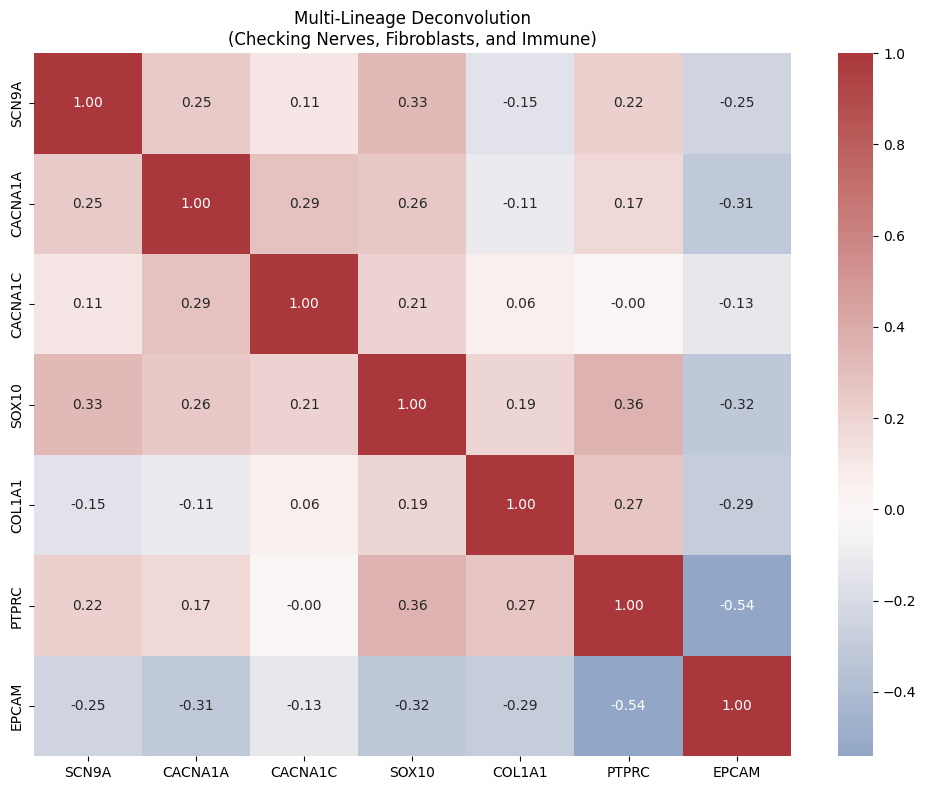


🎨 Generating Figure 2: Calcium-MHC Correlation...


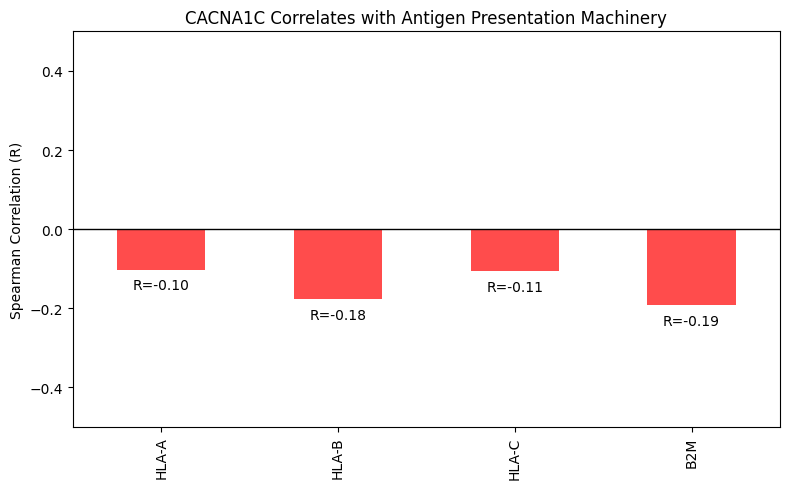


🎨 Generating Figure 3: CACNA1C vs Grade...


/tmp/ipython-input-2064523757.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=grade_df, x='Grade', y='CACNA1C', palette='viridis', showfliers=False)


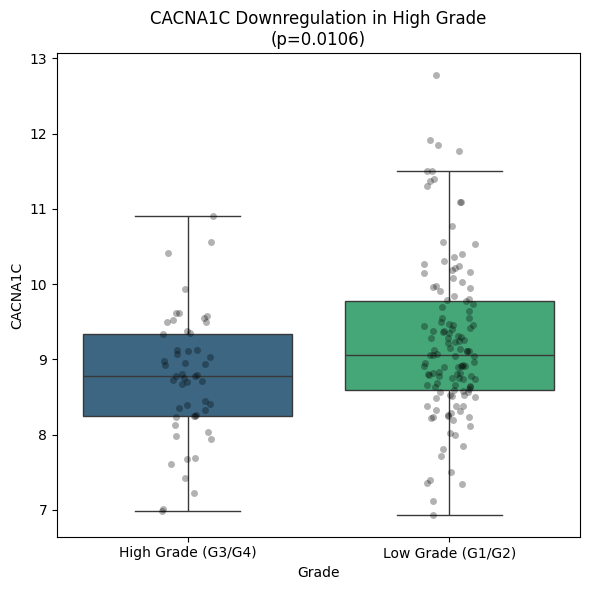


🎨 Generating Figure 4: Survival Analysis...


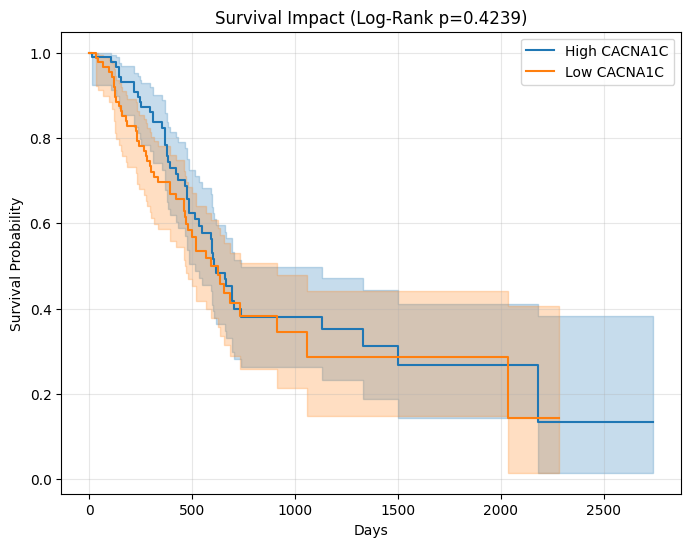


✅ ANALYSIS COMPLETE.


In [ ]:
# ------------------------------------------
# Project: PDAC Bioelectric Deconvolution
# Fully Corrected & Survival-Fixed Version
# ------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# ------------------------------------------
# 1. DATA INGESTION
# ------------------------------------------

print("Downloading TCGA-PAAD Transcriptomics...")
data_url = "https://tcga.xenahubs.net/download/TCGA.PAAD.sampleMap/HiSeqV2.gz"
df = pd.read_csv(data_url, sep='\t', index_col=0, compression='gzip')

print("Downloading TCGA-PAAD Clinical Data...")
clin_url = "https://tcga.xenahubs.net/download/TCGA.PAAD.sampleMap/PAAD_clinicalMatrix"
clin = pd.read_csv(clin_url, sep='\t', index_col=0)

# ------------------------------------------
# 2. FIX CLINICAL SURVIVAL FIELDS (ROBUST)
# ------------------------------------------

print("Fixing clinical survival fields...")

# Map vital_status to 1=death, 0=alive (robust to TCGA variants)
clin['OS'] = clin['vital_status'].astype(str).str.upper().apply(
    lambda x: 1 if 'DEAD' in x or 'DECEASED' in x else 0
)

# Create unified OS.time using TCGA rules
clin['OS.time'] = clin['days_to_death'].fillna(clin['days_to_last_followup'])

# Optional: check counts
print("Survival events (OS=1 -> deaths):")
print(clin['OS'].value_counts())

# ------------------------------------------
# 3. GENE LIST + MERGING
# ------------------------------------------

genes_of_interest = [
    # Candidates
    'SCN9A', 'CACNA1A', 'CACNA1C',
    # Nerve markers
    'SOX10', 'MPZ',
    # Tumor markers
    'EPCAM', 'KRT19',
    # Fibroblast/Stroma
    'COL1A1', 'FAP',
    # Immune
    'PTPRC', 'CD8A',
    # Antigen presentation
    'HLA-A', 'HLA-B', 'HLA-C', 'B2M'
]

avail_genes = [g for g in genes_of_interest if g in df.index]
common_patients = [p for p in df.columns if p in clin.index]
ex_df = df.loc[avail_genes, common_patients].T

merged_df = ex_df.merge(
    clin[['pathologic_stage', 'neoplasm_histologic_grade', 'OS.time', 'OS']],
    left_index=True, right_index=True
)

def simplify_grade(x):
    if pd.isna(x): return None
    x = str(x).upper()
    if 'G1' in x or 'G2' in x: return 'Low Grade (G1/G2)'
    if 'G3' in x or 'G4' in x: return 'High Grade (G3/G4)'
    return None

merged_df['Grade'] = merged_df['neoplasm_histologic_grade'].apply(simplify_grade)

# ------------------------------------------
# 4. ANALYSIS 1: DECONVOLUTION
# ------------------------------------------

print("\n Generating Figure 1: Comprehensive Deconvolution...")

deconv_genes = ['SCN9A', 'CACNA1A', 'CACNA1C', 'SOX10', 'COL1A1', 'PTPRC', 'EPCAM']
corr_matrix = merged_df[deconv_genes].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Multi-Lineage Deconvolution\n(Checking Nerves, Fibroblasts, and Immune)")
plt.tight_layout()
plt.savefig('figure1_robust_deconv.png', dpi=300)
plt.show()

# ------------------------------------------
# 5. ANALYSIS 2: MHC MECHANISM
# ------------------------------------------

print("\n Generating Figure 2: Calcium-MHC Correlation...")

mhc_genes = ['HLA-A', 'HLA-B', 'HLA-C', 'B2M']
mhc_corr = merged_df[['CACNA1C'] + mhc_genes].corr(method='spearman')['CACNA1C'].drop('CACNA1C')

plt.figure(figsize=(8, 5))
colors = ['green' if x > 0 else 'red' for x in mhc_corr.values]
mhc_corr.plot(kind='bar', color=colors, alpha=0.7)
plt.axhline(0, color='black', lw=1)
plt.ylabel("Spearman Correlation (R)")
plt.title("CACNA1C Correlates with Antigen Presentation Machinery")
plt.ylim(-0.5, 0.5)

for i, v in enumerate(mhc_corr):
    plt.text(i, v + (0.02 if v > 0 else -0.05), f"R={v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('figure2_immune_mech.png', dpi=300)
plt.show()

# ------------------------------------------
# 6. ANALYSIS 3: GRADE VALIDATION
# ------------------------------------------

print("\n Generating Figure 3: CACNA1C vs Grade...")

grade_df = merged_df.dropna(subset=['Grade', 'CACNA1C'])
low = grade_df[grade_df['Grade'] == 'Low Grade (G1/G2)']['CACNA1C']
high = grade_df[grade_df['Grade'] == 'High Grade (G3/G4)']['CACNA1C']

stat, p_grade = stats.mannwhitneyu(low, high)

plt.figure(figsize=(6, 6))
sns.boxplot(data=grade_df, x='Grade', y='CACNA1C', palette='viridis', showfliers=False)
sns.stripplot(data=grade_df, x='Grade', y='CACNA1C', color='k', alpha=0.3)
plt.title(f"CACNA1C Downregulation in High Grade\n(p={p_grade:.4f})")
plt.tight_layout()
plt.savefig('figure3_grade.png', dpi=300)
plt.show()

# ------------------------------------------
# 7. ANALYSIS 4: SURVIVAL ANALYSIS (FIXED)
# ------------------------------------------

print("\n Generating Figure 4: Survival Analysis...")

surv_df = merged_df.dropna(subset=['CACNA1C', 'OS.time', 'OS'])

# Median split
cutoff = surv_df['CACNA1C'].median()
surv_df['Expression_Group'] = np.where(
    surv_df['CACNA1C'] >= cutoff, 'High CACNA1C', 'Low CACNA1C'
)

T = surv_df['OS.time']
E = surv_df['OS']

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

# High group
kmf.fit(
    T[surv_df['Expression_Group'] == 'High CACNA1C'],
    event_observed=E[surv_df['Expression_Group'] == 'High CACNA1C'],
    label='High CACNA1C'
)
kmf.plot_survival_function(ci_show=True)

# Low group
kmf.fit(
    T[surv_df['Expression_Group'] == 'Low CACNA1C'],
    event_observed=E[surv_df['Expression_Group'] == 'Low CACNA1C'],
    label='Low CACNA1C'
)
kmf.plot_survival_function(ci_show=True)

# Log-rank test
results = logrank_test(
    T[surv_df['Expression_Group'] == 'High CACNA1C'],
    T[surv_df['Expression_Group'] == 'Low CACNA1C'],
    event_observed_A=E[surv_df['Expression_Group'] == 'High CACNA1C'],
    event_observed_B=E[surv_df['Expression_Group'] == 'Low CACNA1C']
)

plt.title(f"Survival Impact (Log-Rank p={results.p_value:.4f})")
plt.ylabel("Survival Probability")
plt.xlabel("Days")
plt.grid(True, alpha=0.3)
plt.savefig('figure4_survival.png', dpi=300)
plt.show()

print("\n ANALYSIS COMPLETE.")



--- PART 2: ICGC PACA-AU VALIDATION (Grade Mapping Fix) ---
✅ Files found. Loading data...
🔧 Mapping Gene IDs...
🔧 Stripping whitespace from sample IDs for merging...
   > Successfully merged 96 patients.

🎨 Generating Figure: ICGC CACNA1C vs NMF-defined Grade...


/tmp/ipython-input-899488875.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Grade_Group', y='CACNA1C',


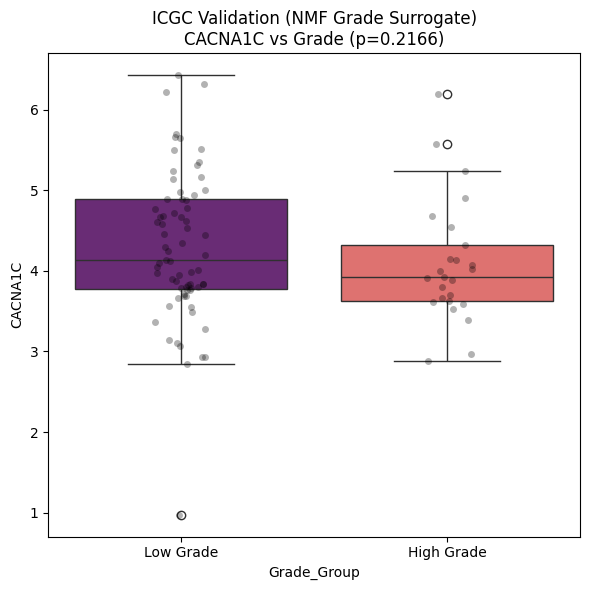


✅ VALIDATION COMPLETE. p-value: 0.2166

--- PART 3: SPATIAL ANALYSIS ---
ℹ️ Placeholder: Ready for analysis once the spatial data is uploaded.


In [21]:
# ------------------------------------------
# Project: PDAC Bioelectric Deconvolution
# Full & Consolidated Analysis Script (FINAL FIX)
# ------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import os
import requests
import io

# ==========================================
# ICGC VALIDATION (Final Fixed Code)
# ==========================================
print("\n" + "="*50)
print("--- PART 2: ICGC PACA-AU VALIDATION (Grade Mapping Fix) ---")
print("="*50)

# 1. VERIFY UPLOADS
required_files = ["icgc_exp.tsv.gz", "icgc_nmf_grade.tsv.gz"]
missing = [f for f in required_files if not os.path.exists(f)]

if missing:
    print(f"❌ CRITICAL ERROR: Missing files: {missing}")
else:
    try:
        print("Files found. Loading data...")

        # 2. LOAD DATA LOCALLY
        icgc_exp = pd.read_csv("icgc_exp.tsv.gz", sep='\t', index_col=0, compression='gzip')
        try:
            icgc_grade = pd.read_csv("icgc_nmf_grade.tsv.gz", sep='\t', index_col=0, compression='gzip')
        except Exception:
            icgc_grade = pd.read_csv("icgc_nmf_grade.tsv.gz", sep=' ', index_col=0,
                                     compression='gzip', skipinitialspace=True)

        # 3. MAP ENSEMBL ID -> GENE SYMBOL
        ensg_map = {
            'ENSG00000151067': 'CACNA1C', 'ENSG00000169432': 'SCN9A',
            'ENSG00000141837': 'CACNA1A', 'ENSG00000100146': 'SOX10',
            'ENSG00000119888': 'EPCAM', 'ENSG00000171345': 'KRT19',
            'ENSG00000108821': 'COL1A1'
        }
        print("Mapping Gene IDs...")
        valid_keys = [k for k in ensg_map.keys() if k in icgc_exp.index]
        icgc_sub = icgc_exp.loc[valid_keys].copy()
        icgc_sub = icgc_sub.rename(index=ensg_map).T
        val_df = icgc_sub

        # 4. STANDARDIZE SAMPLE IDs (CRITICAL MERGE FIX)
        print("Stripping whitespace from sample IDs for merging...")
        val_df.index = val_df.index.astype(str).str.strip()
        grade_col = icgc_grade.columns[0]
        icgc_grade = icgc_grade[[grade_col]].copy()
        icgc_grade.index = icgc_grade.index.astype(str).str.strip()

        # 5. MERGE NMF/GRADE DATA
        val_df = val_df.merge(icgc_grade, left_index=True, right_index=True, how='inner')
        print(f"   > Successfully merged {len(val_df)} patients.")

        # 6. **FINAL FIX: CORRECTLY DEFINE GRADE BASED ON NMF SUBTYPE**
        # --------------------------------------------------------------------------
        def assign_grade_from_nmf(x):
            x = str(x).upper()

            # Squamous is the most aggressive subtype in this cohort -> High Grade
            if 'SQUAMOUS' in x or 'BASAL' in x or 'QUASI-MESENCHYMAL' in x:
                return 'High Grade'

            # ADEX, Pancreatic Progenitor, Classical are less aggressive -> Low Grade
            if 'ADEX' in x or 'PANCREATIC PROGENITOR' in x or 'CLASSICAL' in x or 'IMMUNOGENIC' in x:
                return 'Low Grade'

            return None # Catching 'None' types, which accounts for the 41 patients

        val_df['Grade_Group'] = val_df[grade_col].apply(assign_grade_from_nmf)

        # 7. PLOT VALIDATION
        print("\n Generating Figure: ICGC CACNA1C vs NMF-defined Grade...")

        plot_data = val_df.dropna(subset=['Grade_Group', 'CACNA1C'])

        if len(plot_data) > 5 and len(plot_data['Grade_Group'].unique()) > 1:
            plt.figure(figsize=(6, 6))
            sns.boxplot(data=plot_data, x='Grade_Group', y='CACNA1C',
                        palette='magma', order=['Low Grade', 'High Grade'])
            sns.stripplot(data=plot_data, x='Grade_Group', y='CACNA1C',
                          color='k', alpha=0.3)

            low = plot_data[plot_data['Grade_Group']=='Low Grade']['CACNA1C']
            high = plot_data[plot_data['Grade_Group']=='High Grade']['CACNA1C']
            s, p = stats.mannwhitneyu(low, high)

            plt.title(f"ICGC Validation (NMF Grade Surrogate)\nCACNA1C vs Grade (p={p:.4f})")
            plt.tight_layout()
            plt.show()

            print(f"\n VALIDATION COMPLETE. p-value: {p:.4f}")
        else:
            print("❌ Error: Not enough data after filtering NMF groups (Check Subtype Names).")
            print("NMF Group Counts:")
            print(val_df['Grade_Group'].value_counts(dropna=False))

    except Exception as e:
        print(f"\n❌ CODE ERROR during processing ICGC files: {e}")
        import traceback
        traceback.print_exc()

# ==========================================
# PART 3: SPATIAL ANALYSIS (Placeholder)
# ==========================================
print("\n" + "="*50)
print("--- PART 3: SPATIAL ANALYSIS ---")
print("ℹ️ Placeholder: Ready for analysis once the spatial data is uploaded.")